## Master thesis: Car Sales Forecasting in Finland using Machine Learning

### Install Required Libraries

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pycaret --user

### Loading data

In [1]:
import pandas as pd
import time

# Input filename, path to source files and output filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'
filename = path + 'Retails_ALL_CY11_CY22.xlsx'
external_filename = path + 'External_indicators.xlsx'

start_time = time.time()

# Load files into pandas dataframes
df = pd.concat(pd.read_excel(filename, sheet_name=None), ignore_index=True)
df_external = pd.concat(pd.read_excel(external_filename, sheet_name=None), ignore_index=True)

end_time = time.time()
time_elapsed = end_time - start_time 
print('Completed in %f seconds.' % time_elapsed)

Completed in 168.469176 seconds.


In [2]:
df.shape

(465360, 18)

### Preprocessing data

In [3]:
# As dataset having lot of extra spaces in cell so lets remove them using strip() function
df['RetailCountry'] = df['RetailCountry'].str.strip()
df['vehOrderClassCode'] = df['vehOrderClassCode'].str.strip()
df['orderNumber'] = df['orderNumber'].str.strip()

In [4]:
# Sort by orderNumber
df.sort_values(by=['orderNumber', 'RetailDate'], inplace=True)

In [5]:
# Remove duplicates by "orderNumber"
df.drop_duplicates(subset=['orderNumber'], keep='last', inplace=True)

In [6]:
df.shape

(440355, 18)

In [7]:
# Get only Finland
df = df[(df['RetailCountry'] == 'FIN')]

In [8]:
df.shape

(76849, 18)

In [9]:
# Get only Private orders
df = df[(df['vehOrderClassCode'] == 'P')]

In [10]:
df.shape

(51879, 18)

In [11]:
# Remove unnecessary columns
df.drop(['vehOrderClassCode', 'RetailNSC', 'NSCModelGroupCode',
       'ReportingModelGroup', 'FleetCode', 'DealerCodeRetail',
       'orderCreatedDate', 'RetailCountry', 'ModelGroup',
       'EndItem', 'EIColourCode', 'DealerDeliveryAddrNoRetail',
       'FinancialOwnerCategoryCurrent', 'FinancialOwnerCategoryNext',
       'RetailCount', 'Month'], axis=1, inplace=True)

In [12]:
# Convert RetailDate to date
df['RetailDate'] = pd.to_datetime(df['RetailDate'], dayfirst=True).dt.date
# Get year of the ReailDate
df['year'] = pd.DatetimeIndex(df['RetailDate']).year
# Get month of the RetailDate
df['month'] = pd.DatetimeIndex(df['RetailDate']).month

In [13]:
# Preview dataframe
df

orderNumber  RetailDate  year  month
39789   NNE0103741  2012-01-31  2012      1
818     NNE0119938  2011-01-13  2011      1
125     NNE0124013  2011-01-04  2011      1
4168    NNE0124133  2011-02-18  2011      2
915     NNE0127183  2011-01-16  2011      1
...            ...         ...   ...    ...
464012  NNE0655026  2022-08-31  2022      8
464002  NNE0655127  2022-08-18  2022      8
463993  NNE0655294  2022-08-11  2022      8
464043  NNE0655791  2022-08-29  2022      8
464023  NNE0658466  2022-08-31  2022      8

[51879 rows x 4 columns]

In [14]:
# Generating index by date, grouping by and counting
df = df.groupby(['year', 'month']).size().reset_index(name='Orders')
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df.drop(['year', 'month'], axis=1, inplace=True)
df = df.set_index("Date")

In [15]:
# Preview dataframe
df

Orders
Date              
2011-01-01     625
2011-02-01     444
2011-03-01     686
2011-04-01     489
2011-05-01     535
...            ...
2022-04-01     165
2022-05-01     118
2022-06-01     146
2022-07-01      68
2022-08-01     179

[140 rows x 1 columns]

In [16]:
# Set Date as index in the external dataset
df_external.set_index('Date', inplace=True)

In [17]:
# Merge both dataframes
data = pd.concat([df,df_external], axis=1)

In [18]:
# Preview dataframe
data

Orders   CCI     CPI   CoL  Light_fuel_oil  Diesel  Petrol_95  \
Date                                                                        
2011-01-01     625   0.3  101.78  1783            1.05    1.31       1.51   
2011-02-01     444   0.4  102.40  1794            1.02    1.32       1.50   
2011-03-01     686  -0.2  102.96  1804            1.09    1.38       1.56   
2011-04-01     489  -0.6  103.16  1807            1.10    1.38       1.57   
2011-05-01     535  -1.5  103.21  1808            1.04    1.38       1.59   
...            ...   ...     ...   ...             ...     ...        ...   
2022-04-01     165 -11.7  121.09  2121            1.59    2.22       2.17   
2022-05-01     118 -11.6  122.67  2149            1.74    2.27       2.30   
2022-06-01     146 -14.3  123.56  2165            1.95    2.44       2.57   
2022-07-01      68 -15.9  123.96  2172            1.78    2.27       2.33   
2022-08-01     179 -14.9  124.05  2173            1.62    2.09       2.14   

            Petrol_98  Avg_fuel_price  Passenger_cars  Vans    TIV  \
Date                                                                 
2011-01-01       1.56          1.3575           13788  1205  14993   
2011-02-01       1.56          1.3500            9304   966  10270   
2011-03-01       1.61          1.4100           12585  1342  13927   
2011-04-01       1.63          1.4200           11406  1085  12491   
2011-05-01       1.65          1.4150           13040  1179  14219   
...               ...             ...             ...   ...    ...   
2022-04-01       2.26          2.0600            6432   788   7220   
2022-05-01       2.39          2.1750            7942   856   8798   
2022-06-01       2.67          2.4075            7398   907   8305   
2022-07-01       2.42          2.2000            5503   598   6101   
2022-08-01       2.23          2.0200            7114  1049   8163   

            Unemployment_rate_%  Long_term_interest_rates  GDP  
Date                                                            
2011-01-01                  8.6                  3.270000  0.6  
2011-02-01                  8.5                  3.410000  0.6  
2011-03-01                  9.9                  3.450000  0.6  
2011-04-01                  8.4                  3.570000 -0.2  
2011-05-01                  9.8                  3.320000 -0.2  
...                         ...                       ...  ...  
2022-04-01                  6.9                  1.177000  1.0  
2022-05-01                  7.9                  1.451962  1.0  
2022-06-01                  6.8                  2.072276  1.0  
2022-07-01                  6.6                  1.713857 -0.2  
2022-08-01                  6.7                  1.624904 -0.2  

[140 rows x 15 columns]

In [19]:
data.fillna(0,inplace=True)

In [20]:
# Save data to Excel so we don't need to run previous steps every time
data.to_excel("output.xlsx")  

### ** Execution can start from here **

In [25]:
import pandas as pd

# Load file into a pandas dataframe
file = 'D:/Git_Projects/5. Master_thesis/output.xlsx'
data = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)
data = data.set_index("Date")

In [30]:
import statsmodels.api as sm
orders = data.Orders.to_frame()

In [68]:
orders

# Let's make sure 'date' is actually a date in pandas
data["date"] = pd.to_datetime(data["date"])


value = data["value"]

Orders    float64
dtype: object

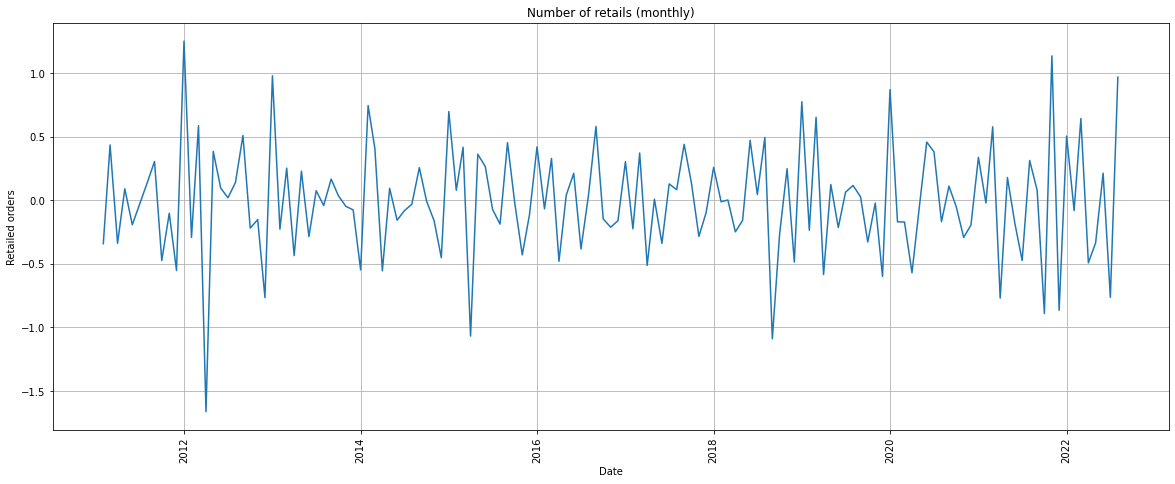

In [70]:
import matplotlib.pyplot as plt
date = pd.to_datetime(orders.index)
plt.figure(figsize=[20, 7.5]); # Set dimensions for figure
plt.plot(date, orders['Orders'])
plt.title('Number of retails (monthly)')
plt.ylabel('Retailed orders')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

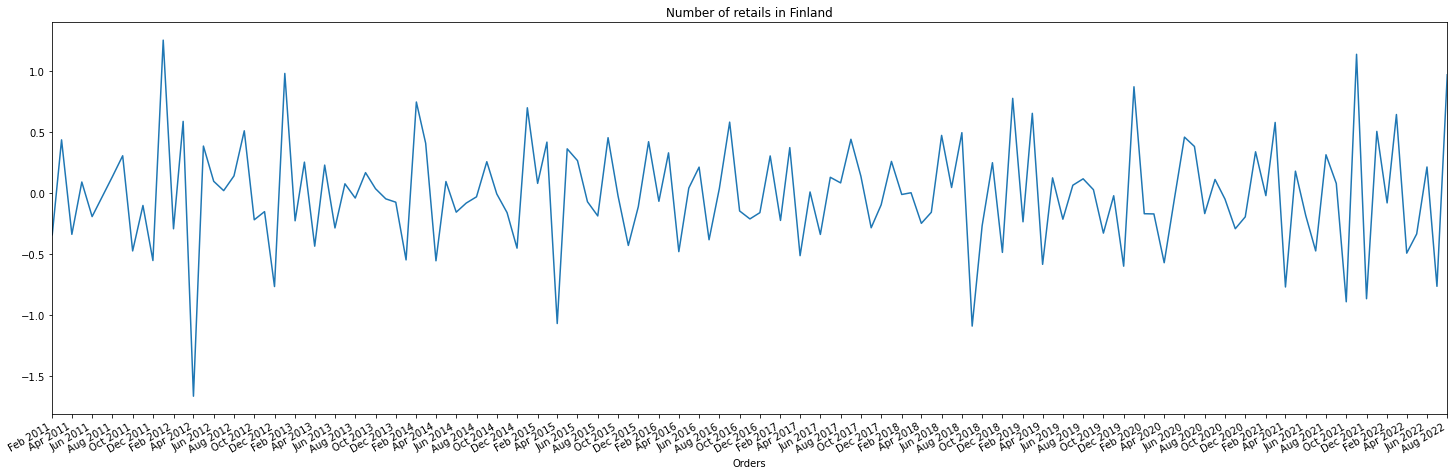

In [81]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(25, 8))

half_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m")    # four digits for year, two for month
month_year_formatter = mdates.DateFormatter('%b %Y')    # The "," is intentional.

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(month_year_formatter)

ax.set_xlim([orders.index.min(), orders.index.max()])
ax.set_title("Number of retails in Finland")
ax.set_xlabel("Orders")
ax.plot(orders.index, orders['Orders'])

fig.autofmt_xdate()

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


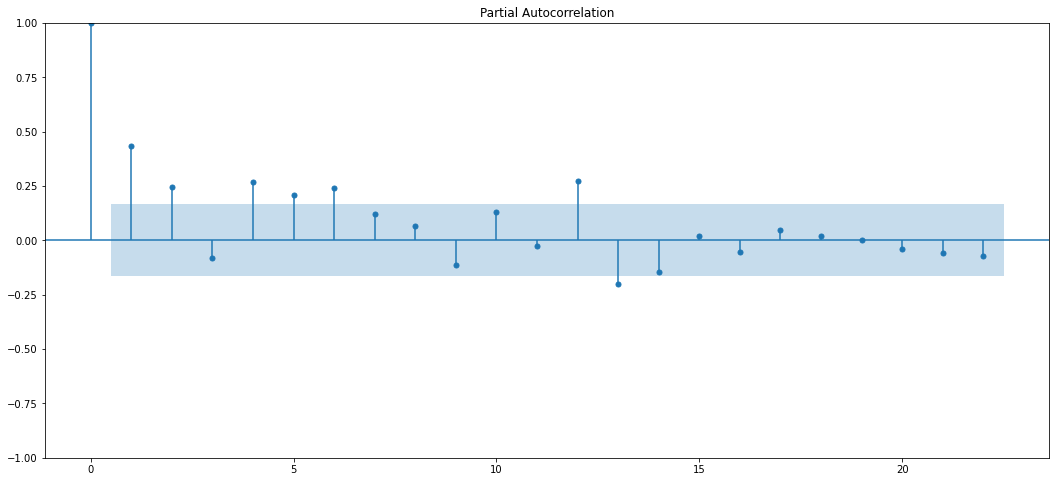

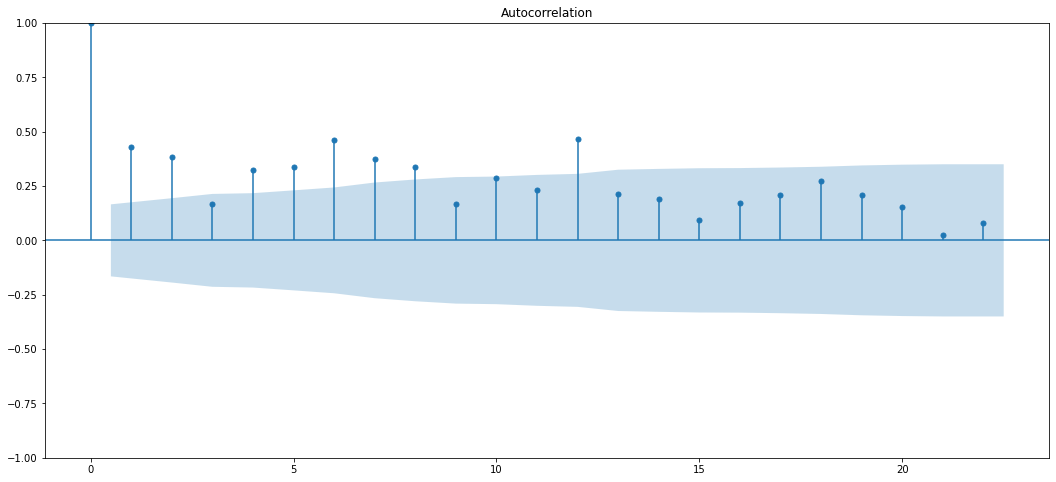

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plot_pacf(orders['Orders']);
plot_acf(orders['Orders']);

In [65]:
from statsmodels.tsa.stattools import adfuller
ad_fuller_result = adfuller(orders['Orders'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.3771316087159746
p-value: 0.980619306972853


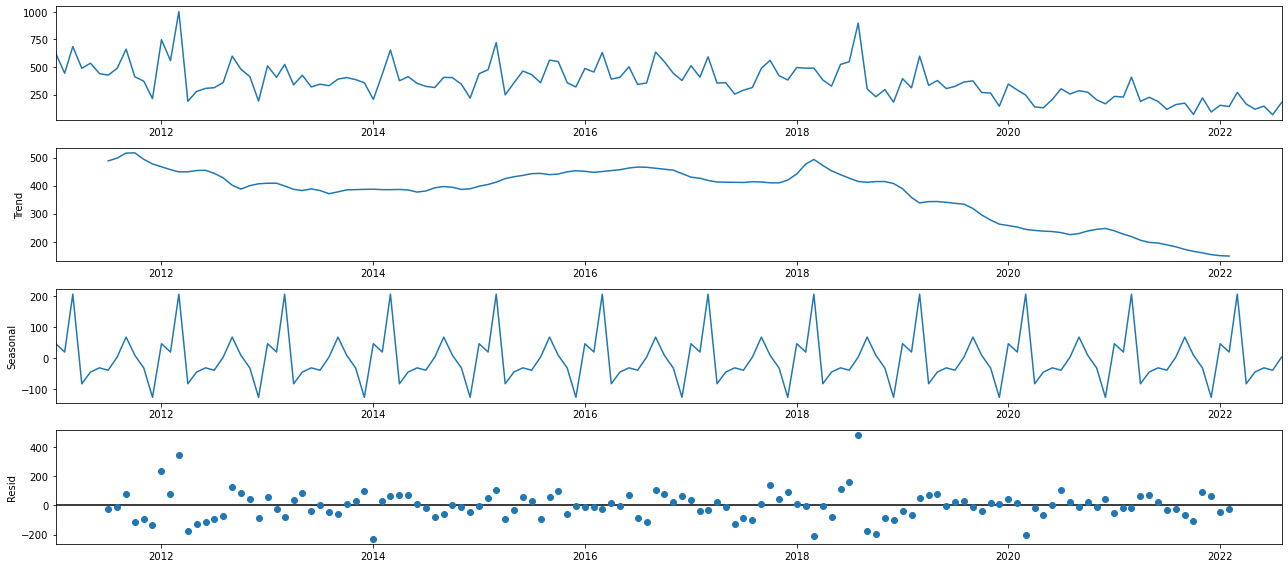

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(orders, model='additive')
fig = decomposition.plot()
plt.show()

In [66]:
import numpy as np
orders['Orders'] = np.log(orders['Orders'])
orders['Orders'] = orders['Orders'].diff()
orders = orders.drop(data.index[0])

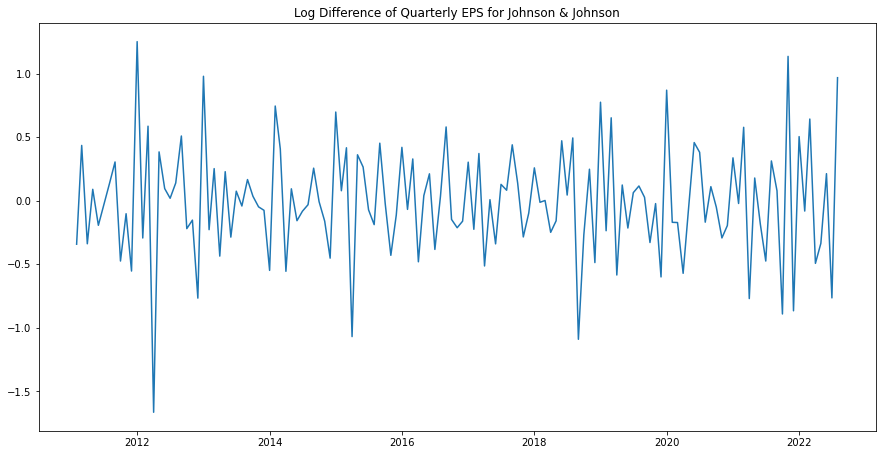

In [67]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(orders['Orders'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [38]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [41]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(orders,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2063.149970560281
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1782.3557591920667
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1633.6928692930953
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1457.7503976522532
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1631.9507558626212


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\ts

ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1594.1657667271174
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1473.5111941505772


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1459.587552774341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1958.3902817576434
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1718.7308207128879


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1614.9269387870615


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1433.3219806775182
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1625.0124889772273


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1565.9997754959325
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1463.2590680417375


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1435.225455662769
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1809.408721875968
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1636.2944406371385
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1667.2891216428025


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1451.1433611273321
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1631.9977627787266
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1584.897360044547


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1485.7226574813549
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1452.748394125312
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1729.954663635082
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1563.0153012681665


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1607.4225898265122


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1389.9150942466079
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1584.9734944362267


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1528.2570652110937
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1442.61547671313


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1391.8860836845154
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1817.2534989755966
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1641.8515678982208
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1624.9585825298157


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1434.5525255179948
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1607.659550653085


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1567.9837074504032
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1444.6617436231384


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1436.533243493998
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1747.5625352765146


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1581.5457250526206
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1614.6047488705894


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1406.9004273032024


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1586.1355751356305


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1541.5578693051339


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1442.7755826838415


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1408.8315716458321
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1777.718721237716
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1610.0241403776188
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1647.4188308673893


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1429.0468140420987
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1597.4876451143207


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1566.3506721868264
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1454.8363825413162


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1431.0321362825243
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1731.2561779318617


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1562.3787458345091
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1602.8047226860667


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1390.5170657165495


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1572.0889833673655


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1527.406940057329


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1429.6670829737263


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1392.4861068889745


In [42]:
mod = sm.tsa.statespace.SARIMAX(orders,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2943      0.065      4.532      0.000       0.167       0.422
ar.S.L12      -0.0222      0.160     -0.139      0.890      -0.336       0.291
ma.S.L12      -0.4818      0.189     -2.553      0.011      -0.852      -0.112
sigma2      1.594e+04   1402.184     11.370      0.000    1.32e+04    1.87e+04


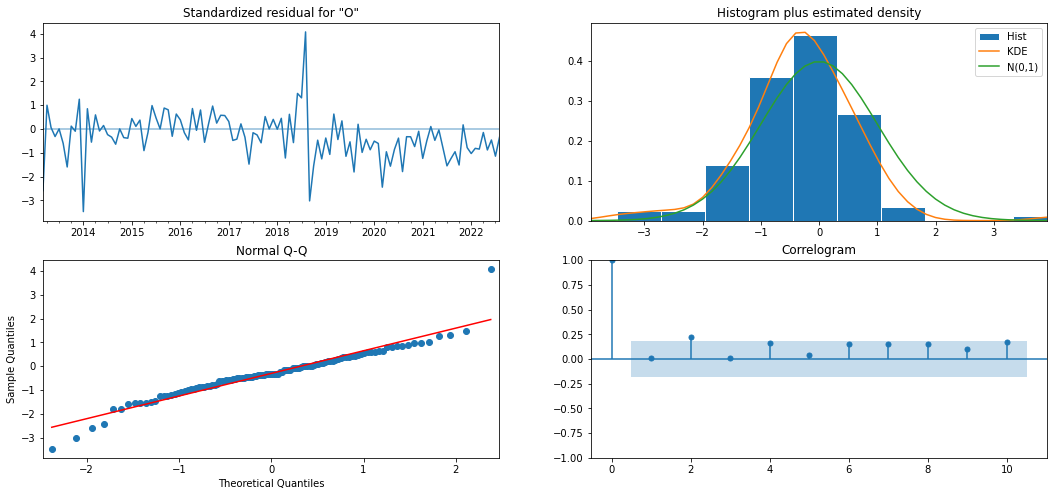

In [43]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

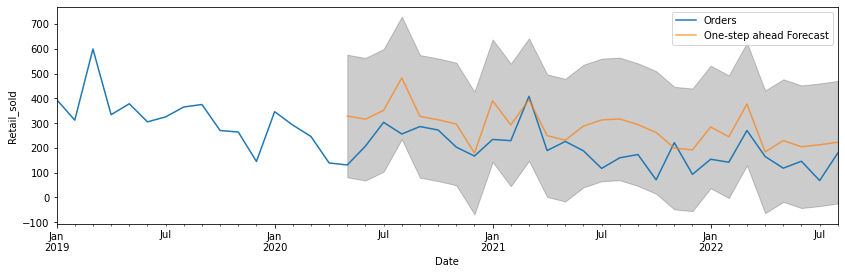

In [52]:
pred = results.get_prediction(start=pd.to_datetime('2020-05-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = orders['2019':].plot()
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [55]:
orders

Orders
Date              
2011-01-01     625
2011-02-01     444
2011-03-01     686
2011-04-01     489
2011-05-01     535
...            ...
2022-04-01     165
2022-05-01     118
2022-06-01     146
2022-07-01      68
2022-08-01     179

[140 rows x 1 columns]

In [56]:
import numpy as np
y_forecasted = pred.predicted_mean
y_truth = orders[:'2020-05-01']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2020-05-01 00:00:00   NaN
2020-06-01 00:00:00   NaN
2020-07-01 00:00:00   NaN
2020-08-01 00:00:00   NaN
2020-09-01 00:00:00   NaN
2020-10-01 00:00:00   NaN
2020-11-01 00:00:00   NaN
2020-12-01 00:00:00   NaN
2021-01-01 00:00:00   NaN
2021-02-01 00:00:00   NaN
2021-03-01 00:00:00   NaN
2021-04-01 00:00:00   NaN
2021-05-01 00:00:00   NaN
2021-06-01 00:00:00   NaN
2021-07-01 00:00:00   NaN
2021-08-01 00:00:00   NaN
2021-09-01 00:00:00   NaN
2021-10-01 00:00:00   NaN
2021-11-01 00:00:00   NaN
2021-12-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2022-02-01 00:00:00   NaN
2022-03-01 00:00:00   NaN
2022-04-01 00:00:00   NaN
2022-05-01 00:00:00   NaN
2022-06-01 00:00:00   NaN
2022-07-01 00:00:00   NaN
2022-08-01 00:00:00   NaN
Orders                NaN
dtype: float64
The Root Mean Squared Error is 2020-05-01 00:00:00   NaN
2020-06-01 00:00:00   NaN
2020-07-01 00:00:00   NaN
2020-08-01 00:00:00   NaN
2020-09-01 00:00:00   NaN
2020-10-01 00:00:00   NaN
2020-11-01 00:00:0

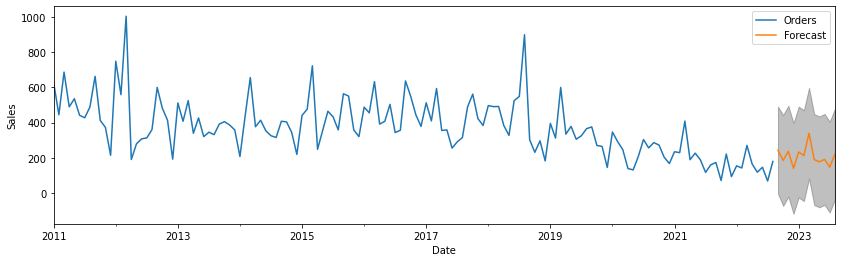

In [57]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = orders.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [24]:
# Data statistics
data.describe()

Orders         CCI         CPI          CoL  Avg_fuel_price  \
count   140.000000  140.000000  140.000000   140.000000      140.000000   
mean    370.564286   -3.393571  110.314929  1932.607143        1.416875   
std     160.395922    4.710607    4.162411    72.955559        0.204342   
min      68.000000  -15.900000  101.780000  1783.000000        1.115000   
25%     262.000000   -6.025000  108.290000  1897.000000        1.296250   
50%     358.000000   -3.700000  109.595000  1920.000000        1.397500   
75%     457.250000    0.100000  112.420000  1969.250000        1.473125   
max    1003.000000    6.800000  124.050000  2173.000000        2.407500   

                TIV  Unemployment_rate_%  Long_term_interest_rates         GDP  
count    140.000000           140.000000                140.000000  140.000000  
mean   10213.071429             8.075714                  0.946106    0.209286  
std     2358.765674             1.313509                  0.975536    1.324745  
min     4286.000000             5.400000                 -0.410000   -6.200000  
25%     8875.750000             7.000000                  0.176818   -0.200000  
50%     9962.500000             8.000000                  0.665000    0.200000  
75%    11221.750000             9.000000                  1.695964    0.700000  
max    25629.000000            11.700000                  3.570000    5.000000

In [25]:
data.isna().sum()

Orders                      0
CCI                         0
CPI                         0
CoL                         0
Avg_fuel_price              0
TIV                         0
Unemployment_rate_%         0
Long_term_interest_rates    0
GDP                         0
dtype: int64

### Plotting data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

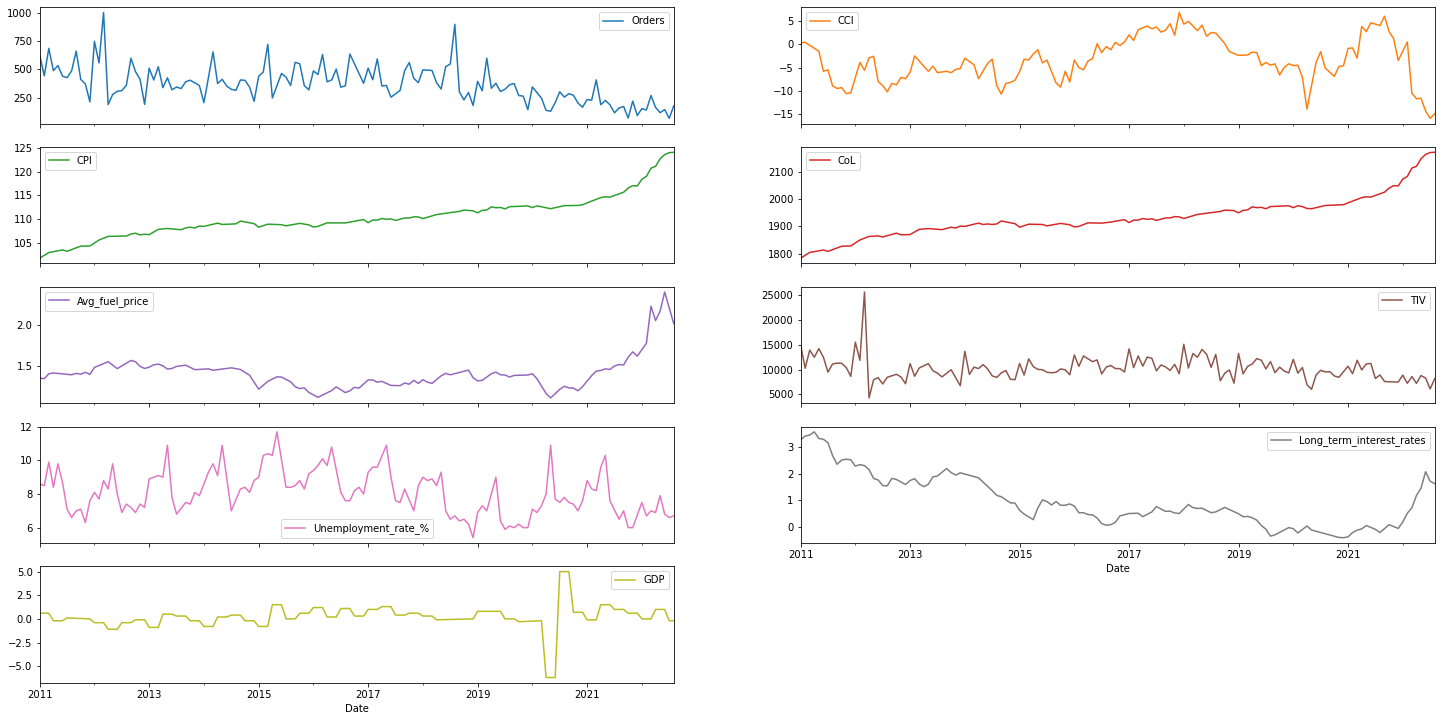

In [26]:
import matplotlib.pyplot as plt
plt.style.use('fast')
plt.rcParams["figure.figsize"] = [25, 15]
data.plot(legend=True, subplots=True, layout=(6,2))

In [27]:
data

Orders   CCI     CPI   CoL  Avg_fuel_price    TIV  \
Date                                                            
2011-01-01     625   0.3  101.78  1783          1.3575  14993   
2011-02-01     444   0.4  102.40  1794          1.3500  10270   
2011-03-01     686  -0.2  102.96  1804          1.4100  13927   
2011-04-01     489  -0.6  103.16  1807          1.4200  12491   
2011-05-01     535  -1.5  103.21  1808          1.4150  14219   
...            ...   ...     ...   ...             ...    ...   
2022-04-01     165 -11.7  121.09  2121          2.0600   7220   
2022-05-01     118 -11.6  122.67  2149          2.1750   8798   
2022-06-01     146 -14.3  123.56  2165          2.4075   8305   
2022-07-01      68 -15.9  123.96  2172          2.2000   6101   
2022-08-01     179 -14.9  124.05  2173          2.0200   8163   

            Unemployment_rate_%  Long_term_interest_rates  GDP  
Date                                                            
2011-01-01                  8.6                  3.270000  0.6  
2011-02-01                  8.5                  3.410000  0.6  
2011-03-01                  9.9                  3.450000  0.6  
2011-04-01                  8.4                  3.570000 -0.2  
2011-05-01                  9.8                  3.320000 -0.2  
...                         ...                       ...  ...  
2022-04-01                  6.9                  1.177000  1.0  
2022-05-01                  7.9                  1.451962  1.0  
2022-06-01                  6.8                  2.072276  1.0  
2022-07-01                  6.6                  1.713857 -0.2  
2022-08-01                  6.7                  1.624904 -0.2  

[140 rows x 9 columns]

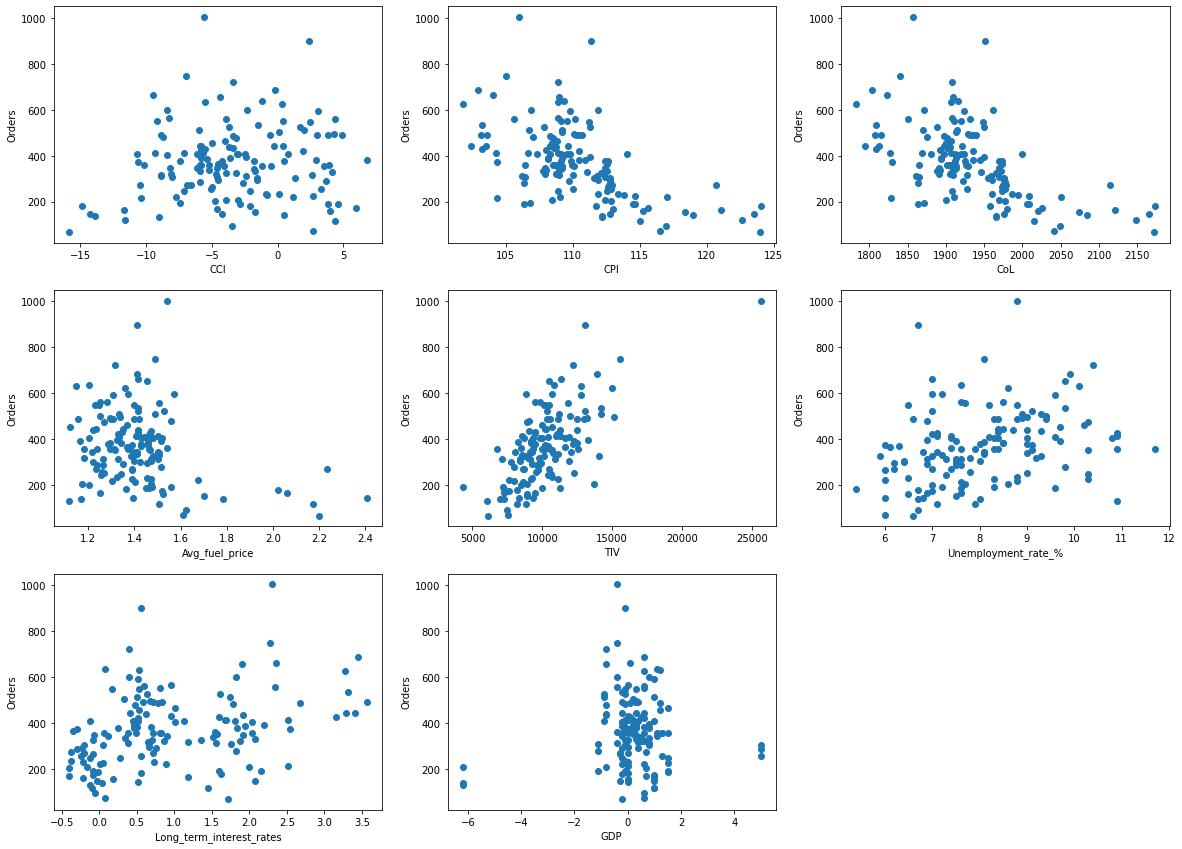

In [28]:
# Define a function to plot the scatterplots of the relationships between 
# all independent variables and the dependent variable
def plot_relationships(df, num_cols):

    dep_var = 'Orders'                          # Dependant variable
    ind_var = df.loc[:, df.columns != 'Orders'] # Independant variables
    figs = len(df.columns) - 1                  # Number of figures 

    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    
    fig = 1
    plt.figure(figsize=(20,20))
    
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

plot_relationships(data,3)

<AxesSubplot:>

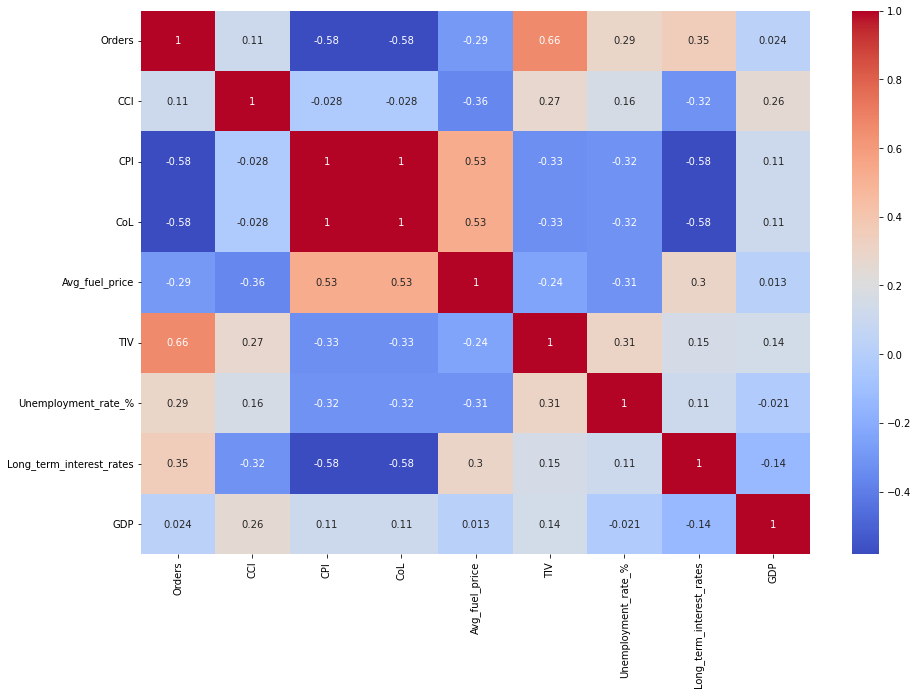

In [29]:
# Import seaborn
import seaborn as sns

# Plot the correlations as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2g')

In [30]:
data.columns

Index(['Orders', 'CCI', 'CPI', 'CoL', 'Avg_fuel_price', 'TIV',
       'Unemployment_rate_%', 'Long_term_interest_rates', 'GDP'],
      dtype='object')

In [ ]:
# Remove unnecessary columns
data.drop(['CCI', 'CoL', 'Avg_fuel_price',
       'Active_Population_1K_persons', 'Employed_1K_persons',
       'Unemployed_1K_persons', 'Unemployment_rate_%'], axis=1, inplace=True)

### Pandas Profiling

https://github.com/ydataai/pandas-profiling

In [7]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Pandas Profiling Report")

In [8]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


In [9]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 9), (28, 9))

### Pycaret Analysis

https://pycaret.gitbook.io/docs/

In [10]:
from pycaret.regression import *

dataset = data
data_pycaret = dataset.sample(frac=0.8, random_state=42)
data_unseen = dataset.drop(data_pycaret.index)

data_pycaret.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data_pycaret.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

# Initial setup
model_setup=setup(data=data_pycaret,target='Orders')

# Model training and selection
best = compare_models()

# Analyze best model
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
et = create_model('et') # Extra Trees Regressor

In [20]:
br = create_model('br') # Bayesian Ridge

In [21]:
gbr = create_model('gbr') # Gradient Boosting Regressor

In [22]:
rf = create_model('rf') # Random Forest Regressor

In [23]:
lightgbm = create_model('lightgbm') # Light Gradient Boosting Machine

In [11]:
xgb = create_model('xgboost') 

In [12]:
tuned_xgb = tune_model(xgb) # Extreme Gradient Boosting

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

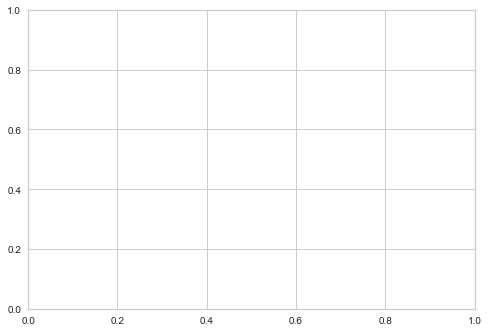

In [13]:
evaluate_model(tuned_xgb)

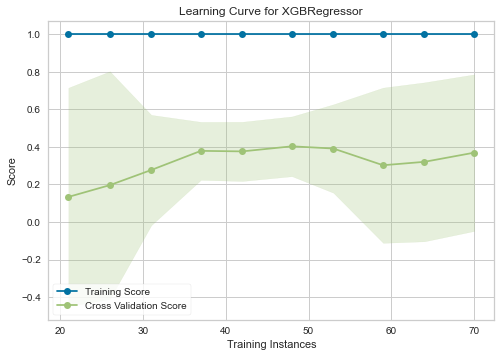

In [14]:
#+-----------------------------+-------------+
#|            Name             |    Plot     |
#+-----------------------------+-------------+
#| Residuals Plot              | ‘residuals’ |
#| Prediction Error Plot       | ‘error’     |
#| Cooks Distance Plot         | ‘cooks’     |
#| Recursive Feature Selection | ‘rfe’       |
#| Learning Curve              | ‘learning’  |
#| Validation Curve            | ‘vc’        |
#| Manifold Learning           | ‘manifold’  |
#| Feature Importance          | ‘feature’   |
#| Model Hyperparameter        | ‘parameter’ |
#+-----------------------------+-------------+

plot_model(tuned_xgb, plot ='learning')

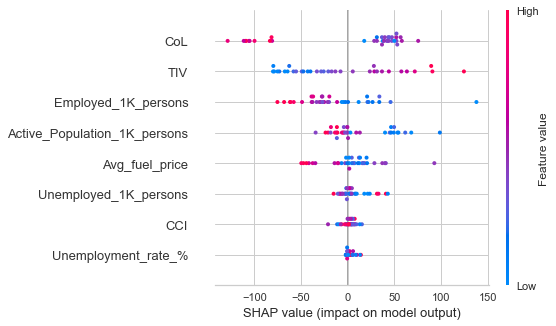

In [15]:
interpret_model(tuned_xgb)

In [16]:
predict_model(tuned_xgb)

CCI     CoL  Avg_fuel_price      TIV  Active_Population_1K_persons  \
0   -2.5  1881.0          1.5200   8657.0                        2621.0   
1    4.9  1935.0          1.3075  10314.0                        2669.0   
2    2.5  1948.0          1.3975  10453.0                        2780.0   
3   -8.9  1815.0          1.3975  11122.0                        2675.0   
4   -3.4  1902.0          1.3475   9467.0                        2704.0   
5    0.5  2084.0          1.7825   7239.0                        2755.0   
6   -3.2  1902.0          1.2700   8904.0                        2627.0   
7    4.4  1931.0          1.2825   9838.0                        2649.0   
8    4.3  1929.0          1.3375  15092.0                        2653.0   
9   -5.4  1894.0          1.4600   8249.0                        2619.0   
10  -0.3  1921.0          1.2350  10192.0                        2599.0   
11  -5.5  1808.0          1.4150   9490.0                        2732.0   
12  -4.5  1976.0          1.3500   9289.0                        2663.0   
13  -2.6  1864.0          1.5150   7942.0                        2762.0   
14   3.0  1931.0          1.2975  10542.0                        2644.0   
15   4.0  2020.0          1.5225   8914.0                        2767.0   
16  -7.7  1910.0          1.3025   7977.0                        2609.0   
17   2.7  2041.0          1.6125   7556.0                        2734.0   
18  -6.6  1975.0          1.3900  10495.0                        2698.0   
19  -9.2  1911.0          1.2300  10127.0                        2646.0   
20   4.1  1946.0          1.3850  14077.0                        2783.0   
21  -1.8  1912.0          1.2150   9125.0                        2697.0   
22  -8.2  1913.0          1.3925   8037.0                        2614.0   
23  -1.7  2074.0          1.7025   8892.0                        2739.0   
24  -5.8  1908.0          1.2375   9961.0                        2584.0   
25   2.6  1927.0          1.2650  10933.0                        2672.0   
26  -4.6  1980.0          1.2525   9473.0                        2671.0   
27  -5.8  1892.0          1.4675  11191.0                        2751.0   
28  -2.4  1950.0          1.3225  13231.0                        2662.0   
29   4.6  2008.0          1.4625  11246.0                        2898.0   
30  -4.6  1969.0          1.4100  12075.0                        2705.0   
31  -9.3  1827.0          1.4050  11270.0                        2606.0   
32 -10.7  1920.0          1.4625   9334.0                        2626.0   
33  -4.8  1977.0          1.2025   8447.0                        2687.0   

    Employed_1K_persons  Unemployed_1K_persons  Unemployment_rate_%  Orders  \
0                2386.0                  235.0                  9.0     554   
1                2434.0                  234.0                  8.8     697   
2                2599.0                  181.0                  6.5     678   
3                2499.0                  177.0                  6.6     689   
4                2477.0                  227.0                  8.4     578   
5                2570.0                  185.0                  6.7     223   
6                2357.0                  270.0                 10.3     694   
7                2449.0                  201.0                  7.6     763   
8                2414.0                  239.0                  9.0     662   
9                2407.0                  212.0                  8.1     601   
10               2381.0                  218.0                  8.4     662   
11               2538.0                  194.0                  7.1     530   
12               2479.0                  185.0                  6.9     462   
13               2492.0                  270.0                  9.8     411   
14               2425.0                  219.0                  8.3     762   
15               2588.0                  179.0                  6.5     250   
16               2379.0             

### Data split

In [101]:
# Select input and target variables
X = data.drop('Orders', axis=1)
y = data["Orders"]

# Split data into train (80%) and test (20%) sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Print shape
X_train.shape, X_test.shape 

((112, 3), (28, 3))

### Scoring function

In [102]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt

metrics = pd.DataFrame()

def scoring(model_name, model, test_features, test_labels):
    
    # Make predictions
    predictions = model.predict(test_features)
    
    # Calculate metrics
    mae = mean_absolute_error(test_labels, predictions)             # MAE
    mse = mean_squared_error(test_labels, predictions)              # MSE
    rmse = math.sqrt(mse)                                           # RMSE
    msle = mean_squared_log_error(test_labels, predictions)         # R2
    rmsle = math.sqrt(msle)                                         # MSLE
    r2 = r2_score(test_labels, predictions)                         # RMSLE
    errors = abs(predictions - test_labels)                         
    mape = 100 * np.mean(errors / test_labels)                      # MAPE
    accuracy = 100 - mape                                           # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, msle, rmsle, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2', 
                    'Mean Squared Log Error', 
                    'Root Mean Squared Log Error', 
                    'Mean Absolute Percentage Error', 
                    'Accuracy']
    
    # Print metrics    
    print(model_name, 'Model Performance:')                         # Model name
    print('Mean Absolute Error: {:0.4f}.'.format(mae))              # MAE
    print('Mean Squared Error: {:0.4f}.'.format(mse))               # MSE
    print('Root Mean Squared Error: {:0.4f}.'.format(rmse))         # RMSE  
    print('R^2 Score = {:0.4f}.'.format(r2))                        # R2
    print('Mean Squared Log Error: {:0.4f}.'.format(msle))          # MSLE
    print('Root Mean Squared Log Error: {:0.4f}.'.format(rmsle))    # RMSLE
    print('Mean Absolute Percentage Error: {:0.4f}.'.format(mape))  # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                  # Accuracy

    # Plot Actual values vs predicted values
    plt.figure(figsize=(12, 8))    

    df = pd.DataFrame(y_test)    
    
    plt.plot(df.index,y_test, c='g', label="Actual values")                         # Acutal values
    plt.plot(df.index,predictions, c='b', label="Predicted values", ls='--')        # Predicted values    
    plt.title('Actual vs Predictions with ' + model_name)                           # Title
    plt.xlabel('Date')                                                              
    plt.ylabel('Orders')                                                             
    plt.legend()
    plt.show()        

### XGBoost (Extreme Gradient Boosting)

#### Baseline

XGboost version: 1.7.2
XGBRegressor Model Performance:
Mean Absolute Error: 83.9862.
Mean Squared Error: 10912.8012.
Root Mean Squared Error: 104.4644.
R^2 Score = -0.9792.
Mean Squared Log Error: 0.2704.
Root Mean Squared Log Error: 0.5200.
Mean Absolute Percentage Error: 58.7352.
Accuracy = 41.26%.


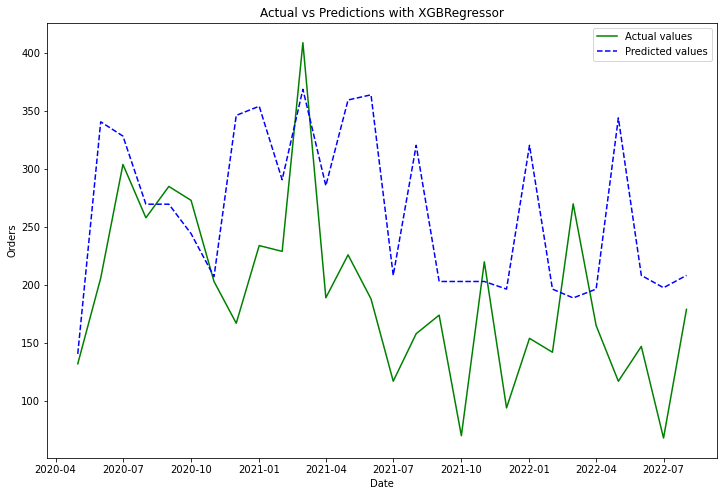

In [103]:
import xgboost as xgb

# Check xgboost version
print("XGboost version:", xgb.__version__)

# Import XGBRegressor
from xgboost import XGBRegressor         
          
# Instantiate the regressor
model = XGBRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

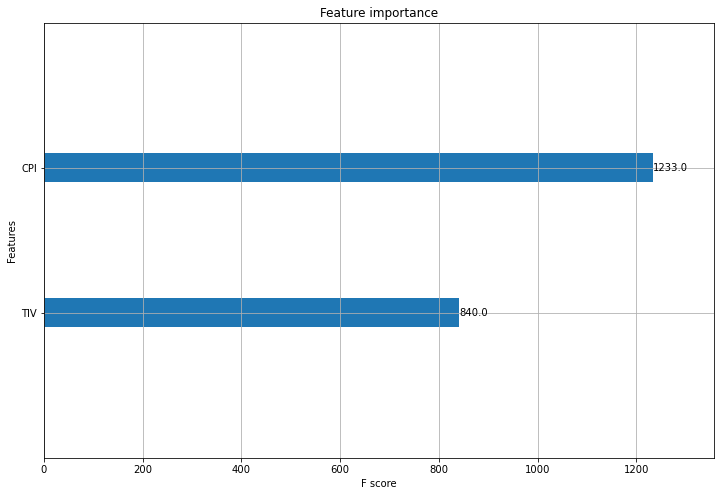

In [104]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)
plt.show();

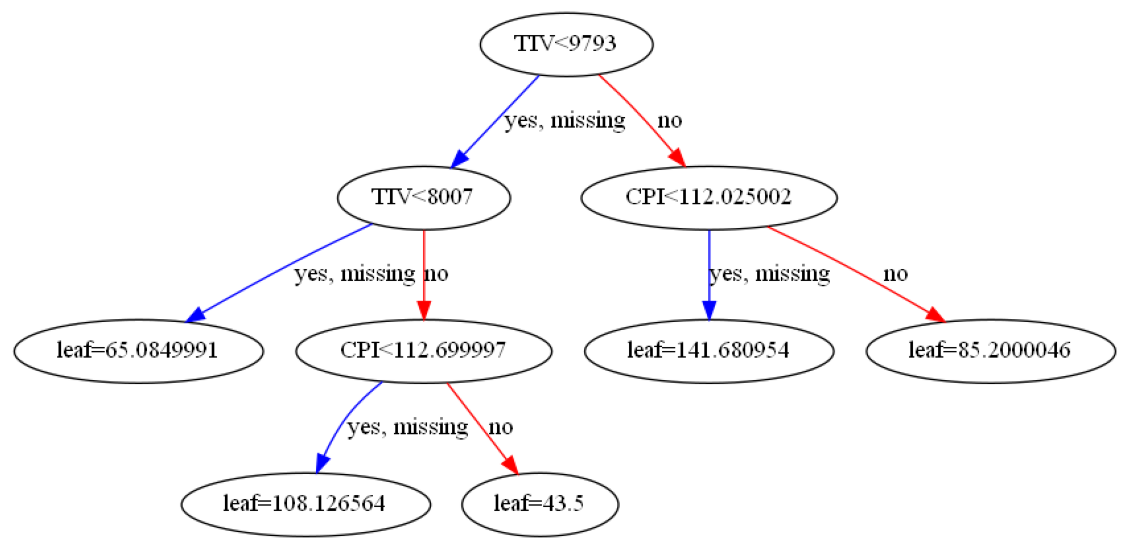

In [105]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_tree(model, ax=ax)
plt.show()

In [106]:
model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

#### Hyperparameters Tuning

In [107]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
xgb_n_estimators = [100, 500, 1000]
xgb_max_depth = [4, 6, 8, 10]
xgb_min_child_weight = [1, 3, 5 , 7]
xgb_eta = [0.001, 0.01, 0.1, 0.2, 0.3]
xgb_subsample = [0.9, 0.5, 0.2, 0.1]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
param_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'eta': xgb_eta,
            'subsample': xgb_subsample,
            'objective': xgb_objective}

# Tune the Model
model_base = XGBRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1920 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 2224 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 3324 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6124 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7657 out of 7680 | elapsed:  2.2min remaining:    0.3s


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

 The best score across ALL searched params:
 0.05514154228769633

 The best parameters across ALL searched params:
 {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'su

[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:  2.2min finished


#### Tuned Model

XGBRegressor Tuned
XGBRegressor Tuned Model Performance:
Mean Absolute Error: 141.3856.
Mean Squared Error: 23797.5258.
Root Mean Squared Error: 154.2645.
R^2 Score = -3.3161.
Mean Squared Log Error: 0.5152.
Root Mean Squared Log Error: 0.7178.
Mean Absolute Percentage Error: 100.2904.
Accuracy = -0.29%.


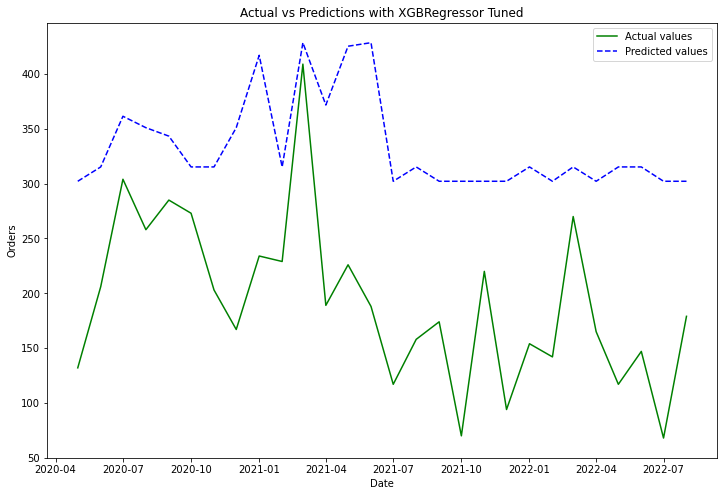

In [108]:
# Create the fnal Extreme Gradient Booster
model_tuned = XGBRegressor(objective = 'reg:squarederror',
                         n_estimators = 100,
                         min_child_weight = 5,
                         max_depth = 4,                         
                         subsample = 0.1,
                         eta = 0.1,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### LightGBM Regression

#### Baseline

LigthGBM version: 3.3.4
LGBMRegressor Model Performance:
Mean Absolute Error: 128.5141.
Mean Squared Error: 22210.2276.
Root Mean Squared Error: 149.0310.
R^2 Score = -1.6572.
Mean Squared Log Error: 0.2326.
Root Mean Squared Log Error: 0.4823.
Mean Absolute Percentage Error: 54.8565.
Accuracy = 45.14%.


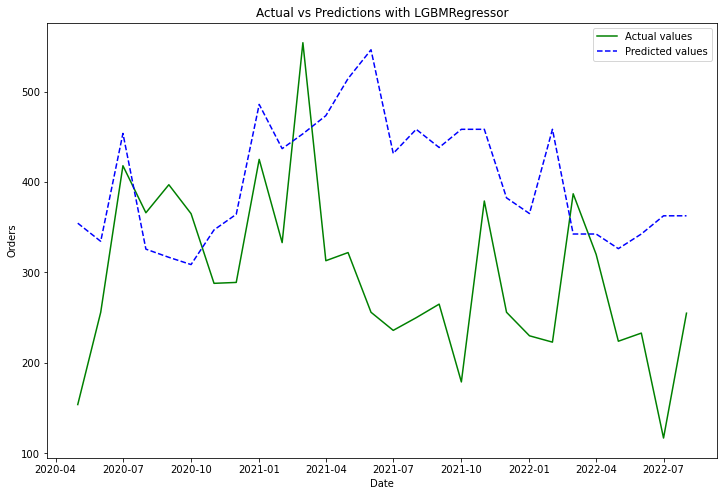

In [65]:
import lightgbm as lgbm

# Check ligthGBM version
print("LigthGBM version:", lgbm.__version__)

# Import LightGBM Regressor
from lightgbm import LGBMRegressor
          
# Instantiate the regressor
model = LGBMRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [66]:
model

LGBMRegressor(random_state=42)

#### Hyperparameters Tuning

In [67]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [100, 500, 1000]
lgbm_max_depth = [4, 6, 8, 10]
lgbm_num_leaves = [1, 3, 5 , 7]
lgbm_learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
lgbm_subsample = [0.9, 0.5, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

# Tune the Model
model_base = LGBMRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 1728 candidates, totalling 6912 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 2840 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 4640 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:   44.9s


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, num_leaves=5,
              random_state=42, subsample=0.0001)

 The best score across ALL searched params:
 0.07812989107779716

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5, 'subsample': 0.0001}


[Parallel(n_jobs=-1)]: Done 6912 out of 6912 | elapsed:   45.8s finished


#### Tuned Model

LGBMRegressor Tuned
LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 137.9974.
Mean Squared Error: 26259.6819.
Root Mean Squared Error: 162.0484.
R^2 Score = -2.1417.
Mean Squared Log Error: 0.2686.
Root Mean Squared Log Error: 0.5183.
Mean Absolute Percentage Error: 60.3085.
Accuracy = 39.69%.


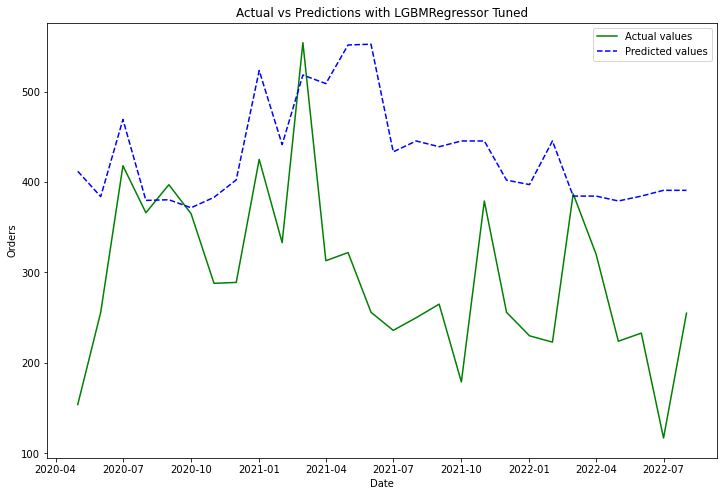

In [68]:
# Create the fnal LightGBM Model
model_tuned = LGBMRegressor(n_estimators = 500,
                         num_leaves= 5,
                         max_depth = 4,                         
                         subsample = 0.0001,
                         learning_rate= 0.01,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

### Random Forest Regression

#### Baseline

RandomForestRegressor Model Performance:
Mean Absolute Error: 145.1639.
Mean Squared Error: 26377.5928.
Root Mean Squared Error: 162.4118.
R^2 Score = -2.1558.
Mean Squared Log Error: 0.2627.
Root Mean Squared Log Error: 0.5125.
Mean Absolute Percentage Error: 61.0253.
Accuracy = 38.97%.


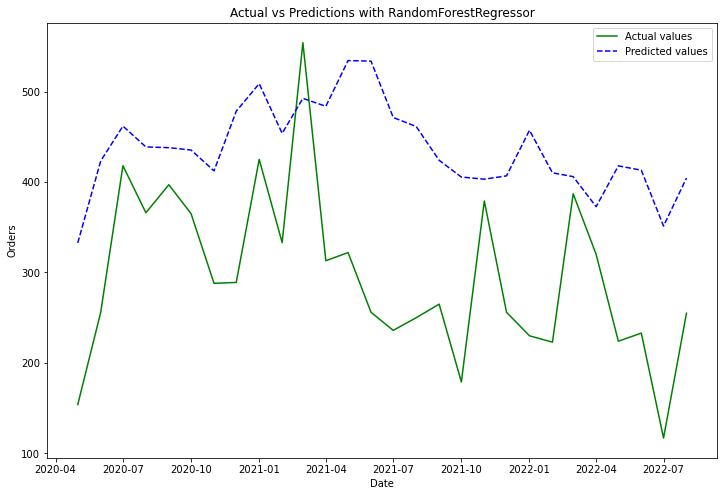

In [69]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
          
# Instantiate the regressor
model = RandomForestRegressor(random_state=42)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Compute and print model score
scoring(model.__class__.__name__, model , X_test, y_test)

In [70]:
model

RandomForestRegressor(random_state=42)

#### Hyperparameters Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

# Set hyperparameters possibilities for model tuning 
rf_n_estimators = [100, 500, 1000]
rf_max_depth = [4, 6, 8, 10]
rf_max_features = ['auto', 'sqrt']
rf_min_samples_leaf = [1, 2, 4]
rf_min_samples_split = [2, 5, 10]
rf_bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'max_features': rf_max_features,
           'min_samples_leaf': rf_min_samples_leaf,
           'min_samples_split': rf_min_samples_split,
           'bootstrap': rf_bootstrap
        }

# Tune the Model
model_base = RandomForestRegressor(random_state=42)

model_grid = GridSearchCV(estimator = model_base, param_grid = param_grid, cv = 4, verbose = 1, n_jobs=-1)

model_grid.fit(X_train, y_train)

model_grid.best_params_

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",model_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",model_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",model_grid.best_params_)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                      random_state=42)

 The best score across ALL searched params:
 0.028845345356432683

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  4.0min finished


#### Tuned Model

RandomForestRegressor Tuned
RandomForestRegressor Tuned Model Performance:
Mean Absolute Error: 150.5736.
Mean Squared Error: 28557.8136.
Root Mean Squared Error: 168.9906.
R^2 Score = -2.4167.
Mean Squared Log Error: 0.2876.
Root Mean Squared Log Error: 0.5363.
Mean Absolute Percentage Error: 64.6067.
Accuracy = 35.39%.


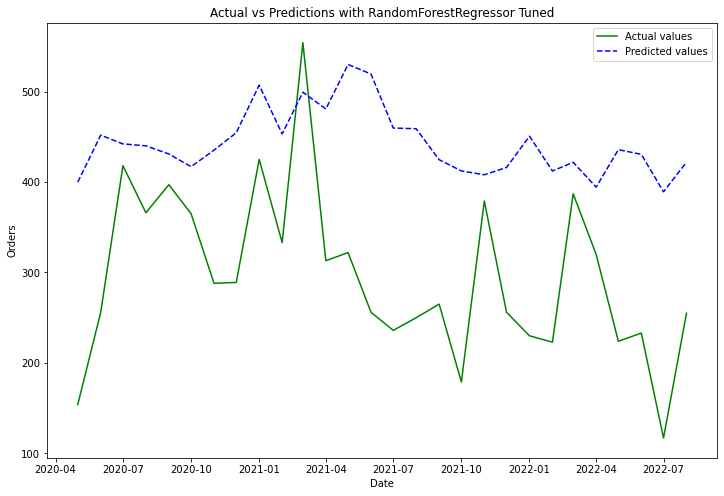

In [72]:
# Create the fnal Random Forest Regressor Model
model_tuned = RandomForestRegressor(n_estimators = 100,
                         max_depth = 8,                         
                         max_features = 'auto',
                         min_samples_leaf= 2,
                         min_samples_split = 10,
                         bootstrap = True,
                         random_state = 42)

# Fit the regressor to the training data
model_tuned.fit(X_train, y_train)

# Compute and print model score
model_name = model_tuned.__class__.__name__ + ' Tuned'
print(model_name)
scoring(model_name, model_tuned, X_test, y_test)

## Summary

In [73]:
metrics

XGBRegressor  XGBRegressor Tuned  \
Mean Absolute Error               110.201332          157.115278   
Mean Squared Error              17548.644245        31778.883339   
Root Mean Squared Error           132.471296          178.266327   
R^2                                -1.099534           -2.802051   
Mean Squared Log Error              0.185415            0.307903   
Root Mean Squared Log Error         0.430598            0.554890   
Mean Absolute Percentage Error     46.729228           67.692136   
Accuracy                           53.270772           32.307864   

                                LGBMRegressor  LGBMRegressor Tuned  \
Mean Absolute Error                128.514080           137.997399   
Mean Squared Error               22210.227609         26259.681917   
Root Mean Squared Error            149.030962           162.048394   
R^2                                 -1.657250            -2.141730   
Mean Squared Log Error               0.232637             0.268632   
Root Mean Squared Log Error          0.482324             0.518297   
Mean Absolute Percentage Error      54.856525            60.308521   
Accuracy                            45.143475            39.691479   

                                RandomForestRegressor  \
Mean Absolute Error                        145.163929   
Mean Squared Error                       26377.592846   
Root Mean Squared Error                    162.411800   
R^2                                         -2.155837   
Mean Squared Log Error                       0.262700   
Root Mean Squared Log Error                  0.512543   
Mean Absolute Percentage Error              61.025307   
Accuracy                                    38.974693   

                                RandomForestRegressor Tuned  
Mean Absolute Error                              150.573636  
Mean Squared Error                             28557.813619  
Root Mean Squared Error                          168.990573  
R^2                                               -2.416680  
Mean Squared Log Error                             0.287633  
Root Mean Squared Log Error                        0.536314  
Mean Absolute Percentage Error                    64.606669  
Accuracy                                          35.393331

# Other tests

### XGBoost (Extreme Gradient Boosting)

In [12]:
import xgboost as xgb
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(random_state=42)
xgb = xgb_regressor.fit(X_train, y_train)

scoring(xgb, X_test, y_test)

Model Performance
Mean Absolute Error: 110.2013.
Mean Squared Error: 17548.6442.
R^2 Score = -1.0995.
Accuracy = 53.27%.


In [13]:
xgb.feature_importances_

array([0.06292622, 0.19028747, 0.        , 0.08134924, 0.32268733,
       0.18839407, 0.07928713, 0.05888204, 0.0161865 ], dtype=float32)

In [14]:
xgb.plot_importance(xgb_regressor, ax=plt.gca())

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

### Cross-validation

In [15]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a function that compares the CV perfromance of a set of predetrmined models 
def cv_comparison(models, X, y, cv):
    cv_accuracies = pd.DataFrame()
    maes = []
    mses = []
    r2s = []
    accs = []
    
    # Loop through the models, run a CV, add the average scores to the DataFrame and the scores of all CVs to the list
    for model in models:
        mae = -np.round(cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv), 4)
        maes.append(mae)
        mae_avg = round(mae.mean(), 4)
        mse = -np.round(cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv), 4)
        mses.append(mse)
        mse_avg = round(mse.mean(), 4)
        r2 = np.round(cross_val_score(model, X, y, scoring='r2', cv=cv), 4)
        r2s.append(r2)
        r2_avg = round(r2.mean(), 4)
        acc = np.round((100 - (100 * (mae * len(X))) / sum(y)), 4)
        accs.append(acc)
        acc_avg = round(acc.mean(), 4)
        cv_accuracies[str(model)] = [mae_avg, mse_avg, r2_avg, acc_avg]
    cv_accuracies.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return cv_accuracies, maes, mses, r2s, accs

# Create the models to be tested
mlgbm = lgbm.LGBMRegressor()
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb_regressor = XGBRegressor(random_state=42)

models = [mlgbm, rf_reg, xgb_reg]

# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

In [16]:
r2_comp = pd.DataFrame(r2s, index=comp.columns, columns=['1st Fold', '2nd Fold', '3rd Fold', 
                                                         '4th Fold'])

r2_comp['Average'] = np.round(r2_comp.mean(axis=1),4)

r2_comp

1st Fold  2nd Fold  \
LGBMRegressor()                                       0.8006    0.7286   
RandomForestRegressor(random_state=42)                0.9872    0.9921   
XGBRegressor(base_score=None, booster=None, cal...    0.9935    0.9896   

                                                    3rd Fold  4th Fold  \
LGBMRegressor()                                       0.8202    0.8027   
RandomForestRegressor(random_state=42)                0.9889    0.9521   
XGBRegressor(base_score=None, booster=None, cal...    0.9944    0.9765   

                                                    Average  
LGBMRegressor()                                      0.7880  
RandomForestRegressor(random_state=42)               0.9801  
XGBRegressor(base_score=None, booster=None, cal...   0.9885

### Hyperparameters Tuning - Random Forest

In [17]:
# Set hyperparameters possibilities for tuning Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
rf_max_depth.append(None)
rf_max_features = ['auto', 'sqrt', 'log2']
rf_criterion = ['mse', 'absolute_error']
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]
rf_min_impurity_decrease = [0.0, 0.05, 0.1]
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_grid

{'n_estimators': [200, 400, 600, 800, 1000],
 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'criterion': ['mse', 'absolute_error'],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'min_impurity_decrease': [0.0, 0.05, 0.1],
 'bootstrap': [True, False]}

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Tune the Random Forest Model
rf_base = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

rf_random.fit(X_train_temp, y_train_temp)

rf_random.best_estimator_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=35,
                      min_impurity_decrease=0.1, min_samples_split=4,
                      n_estimators=600)

### Hyperparameters Tuning - XGBoost (Extreme Gradient Boosting)

In [19]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist'
]
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

# Tune the XGBoost Model
xgb_base = XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

xgb_random.fit(X_train_temp, y_train_temp)

xgb_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'tree_method': 'auto',
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 6,
 'gamma': 0,
 'eta': 0.30000000000000004}

### Final Evaluation

In [20]:
# Create the final LigthGBM

# Create the final Random Forest
rf_final = RandomForestRegressor(n_estimators = 600,
                                 min_samples_split = 4,
                                 min_impurity_decrease = 0.1,
                                 max_features = 'sqrt',
                                 max_depth = 35,
                                 criterion = 'absolute_error',
                                 bootstrap = False,
                                 random_state = 42)

# Create the fnal Extreme Gradient Booster
xgb_final = XGBRegressor(tree_method = 'auto',
                         objective = 'reg:squarederror',
                         n_estimators = 200,
                         min_child_weight = 2,
                         max_depth = 6,
                         gamma = 0,
                         eta = 0.3,
                         random_state = 42)

# Train the models using 80% of the original data
# LGBM goes here --
rf_final.fit(X_train_temp, y_train_temp)
xgb_final.fit(X_train_temp, y_train_temp)

# Define a function that compares all final models
def final_comparison(models, test_features, test_labels):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        mae = round(mean_absolute_error(test_labels, predictions), 4)
        mse = round(mean_squared_error(test_labels, predictions), 4)
        r2 = round(r2_score(test_labels, predictions), 4)
        errors = abs(predictions - test_labels)
        mape = 100 * np.mean(errors / test_labels)
        accuracy = round(100 - mape, 4)
        scores[str(model)] = [mae, mse, r2, accuracy]
    scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Accuracy']
    return scores
    
# Run the Cross-Validation comparison with the models used in this analysis
comp, maes, mses, r2s, accs = cv_comparison(models, X_train_temp, y_train_temp, 4)

comp

LGBMRegressor()  RandomForestRegressor(random_state=42)  \
Mean Absolute Error          60.6684                                 12.0140   
Mean Squared Error         8132.2444                                821.6734   
R^2                           0.7880                                  0.9801   
Accuracy                     89.2095                                 97.8632   

                     XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=None, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=None, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=100, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=42, ...)  
Mean Absolute Error                                            12.9273                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Mean Squared Error                                            451.0516                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
R^2                                                             0.9885                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Accuracy                                                       97.7008

### XGBoost (Extreme Gradient Boosting)

In [20]:
import xgboost as xgb

# check xgboost version
print(xgb.__version__)

# Select input and target variables
X = data.drop(['Orders'], axis=1)
y = data["Orders"]

# Create the DMatrix 
dmatrix = xgb.DMatrix(data=X, label=y)

# Definiing params
params={"objective":"reg:squarederror","max_depth":4}

# L1 regularization
reg_params = [1,10,100]
rmses_l1=[]

for reg in reg_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=dmatrix, params=params,nfold=4,num_boost_round=10,metrics="rmse",as_pandas=True,seed=123)
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(reg_params,rmses_l1)), columns=["l1","rmse"]))

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# L2 regularization
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

1.7.2
Best rmse as a function of l1:
    l1        rmse
0    1  141.909760
1   10  142.030444
2  100  149.481071
Best rmse as a function of l2:
    l2        rmse
0    1  184.852129
1   10  210.660478
2  100  351.448666


In [118]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg,num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg,num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg,num_trees=9,rankdir="LR")
plt.show()

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'train'

### Model tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

dmatrix = xgb.DMatrix(data=X,label=y)

gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                    'n_estimators': [200],
                    'subsample': np.arange(0.05,1.05,.05)}

gbm = xgb.XGBRegressor()

randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, n_iter=25, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.3, 'n_estimators': 200, 'learning_rate': 0.05}
Lowest RMSE found:  181.18036412771912


In [28]:
# Create the DMatrix
dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

   num_boosting_rounds        rmse
0                    5  183.122624
1                   10  147.596829
2                   15  145.746563


In [21]:
X_train.shape, X_test.shape

((112, 13), (28, 13))

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [25]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 72.653859


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [33]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0       368.897880       12.618361      368.081924      28.865079
1       337.347801       11.430440      337.864388      30.209572
2       308.618192       10.960824      309.358712      31.367627
3       282.799589       10.193485      283.653487      32.242495
4       259.745429        9.594686      261.709599      32.982860

In [34]:
print((cv_results["test-rmse-mean"]).tail(1))

32    115.488021
Name: test-rmse-mean, dtype: float64


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [22]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_tree'

In [119]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

## Choosing classifier

In [120]:
from xgboost import XGBRegressor
import xgboost as xgb
#create an xgboost regression model
model = XGBRegressor()

## Fitting the model

In [121]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

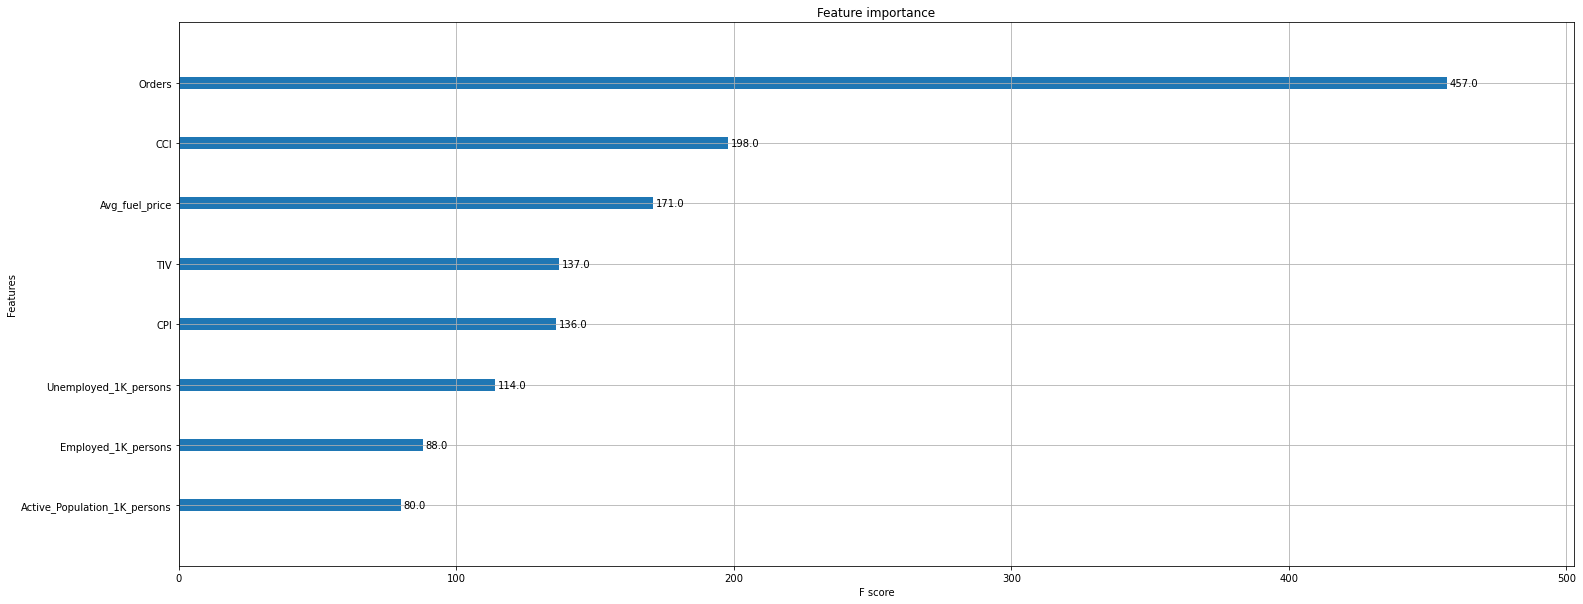

In [122]:
xgb.plot_importance(model, ax=plt.gca())

## Tuning hyperparameters

In [ ]:
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [26]:
# evaluate an xgboost regression model 
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# split data into input and output columns
X, y = datavalues[:, :-1], datavalues[:, -1]
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 20.692 (7.774)


In [51]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [52]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', \
                           n_estimators=1000, \
                          nthread=24)
reg.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', ...)

In [53]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 68.086
